# MIDI music generation with GAN
In this notebook we'll be presenting various approaches for training a GAN model that generates music in the form of MIDI (Musical Instrument Digital Interface) files.

Notebook presented for the A.A. 2023/2024 Deep Learning project.

Group members:
- Valerio Di Zio - valerio.dizio@studio.unibo.it
- Francesco Magnani - francesco.magnani14@studio.unibo.it
- Luca Rubboli - luca.rubboli2@studio.unibo.it

## Installation of libraries

In this notebook only 3 additional libraries are needed (plus the ones already installed on Colab runtimes):
- `pretty_midi` is a utility library to manage MIDI files
- `miditok` is library that provides several implementations of MIDI tokenization algorithms, useful for training AI models on tokens that represent MIDI data
- `fluidsynth` is a utility library to render MIDI files inside colab as audio

In [ ]:
%%capture
!pip install pretty_midi
!pip install miditok

!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

## Dataset Download

We will use the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) for training the first GAN model.

This dataset contains MIDI files taken from several piano performances.

In [ ]:
%%capture
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
!unzip 'maestro-v3.0.0-midi.zip'
!rm 'maestro-v3.0.0-midi.zip'
dataset_path = "maestro-v3.0.0"

## Libraries
Here we import all the necessary libraries for this notebook.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import glob

import os
import random
import datetime
import shutil
from pathlib import Path
import pretty_midi
import numpy as np
from miditok import REMI, TokenizerConfig
import json
from miditok.utils import split_files_for_training
from miditok.data_augmentation import augment_dataset
from random import shuffle
from tqdm import tqdm

from IPython import display

## File setup

Before processing the MIDI files, we first organize them by moving each file into a new folder named midis and renaming them sequentially using integer indices.

In [ ]:
_SAMPLING_RATE = 16000

def display_audio(file, seconds=30):
  pm = pretty_midi.PrettyMIDI(file)
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)

  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
midi_paths = list(Path(dataset_path).resolve().glob("**/*.mid")) + list(Path(dataset_path).resolve().glob("**/*.midi"))

midis_dir = "midis"
os.makedirs(midis_dir, exist_ok=True)


for i, midi_path in enumerate(midi_paths):
  new_midi_path = os.path.join(midis_dir, f"{i}.midi")
  shutil.move(str(midi_path), new_midi_path)


midis = list(Path("midis").resolve().glob("**/*.mid")) + list(Path("midis").resolve().glob("**/*.midi"))

def sample():
  return str(random.choice(midis))

# Data analysis and preparation



## MIDI format

The **MIDI** (Musical Instrument Digital Interface) file format is a standard for representing musical performance data. It doesn’t store actual audio but rather instructions for playback, such as notes, timing, and instrument settings.

The key components contained inside MIDI files are:
1.	**Tracks**: MIDI files contain one or more tracks, each holding a sequence of events.
2.	**Events**:
  - *Note On/Off*: Indicates when a note starts and stops, along with its pitch and velocity (volume).
	- *Control Changes*: Adjust settings like volume, pan, or effects.
	- *Program Changes*: Switches instruments (e.g. piano to guitar).
	- *Meta Events*: Provide additional information like tempo, time signature, and track names.
3.	**Channels**: MIDI supports up to 16 channels, each typically assigned to a different instrument.
4.	**Timing**: MIDI uses ticks (subdivisions of a beat) to precisely time events.

Many python libraries to handle MIDI files exist, here `pretty_midi` will be used as it appears sufficiently flexible and easy to use.

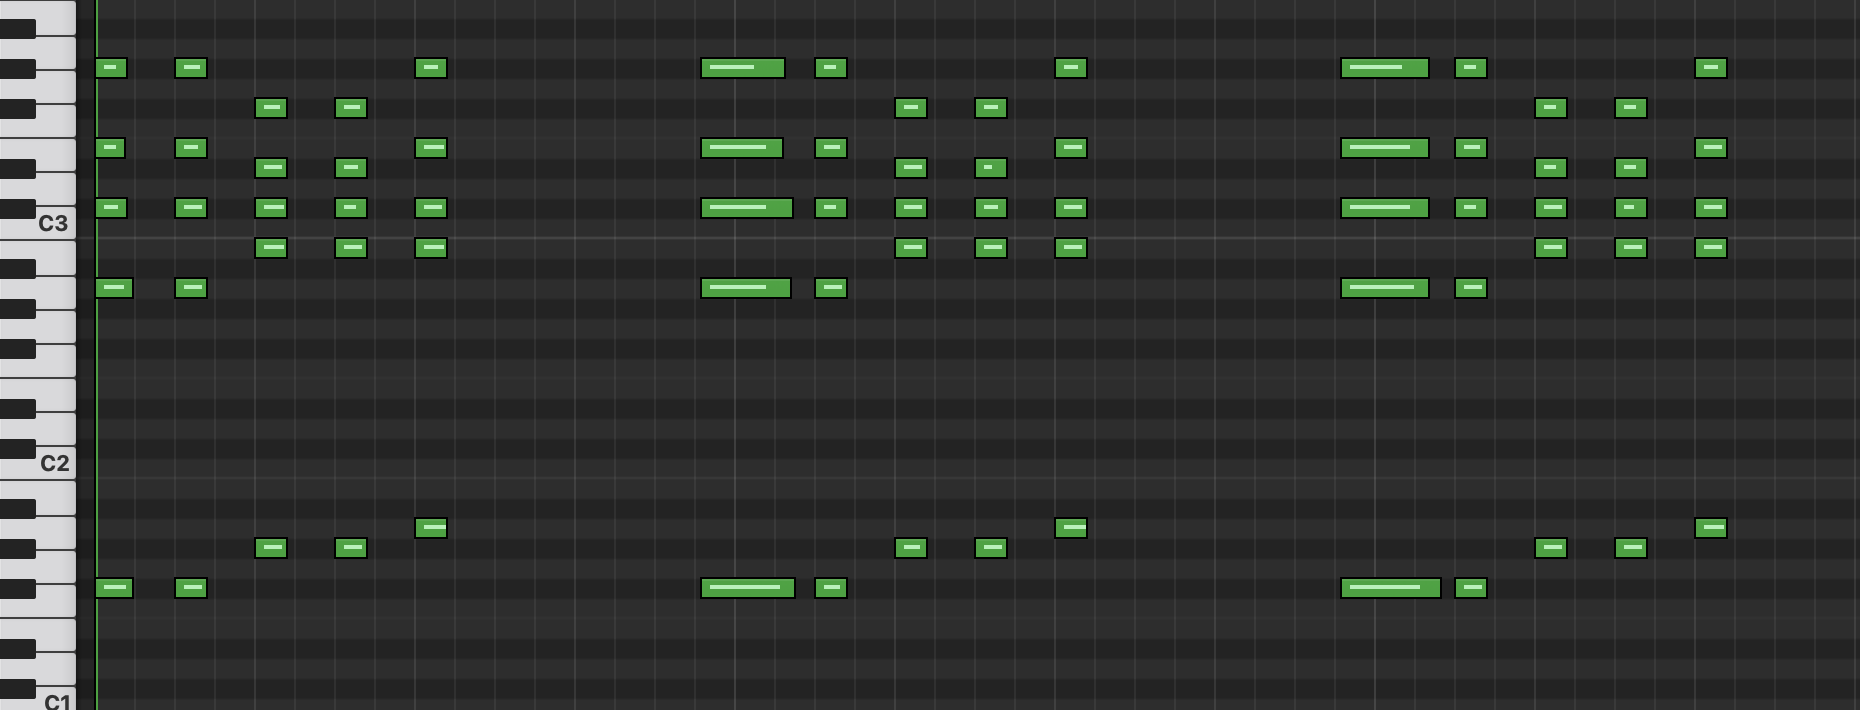

## Tokenization

We cannot directly use MIDI files as input for an AI model, so we must transform them into a numerical representation, similar to how text data is processed for models. To achieve this, we need a **tokenizer**.

A tokenizer is a tool that converts the raw MIDI data into a sequence of *tokens* that the AI model can understand.

In the context of MIDI tokenization, each token represents a specific musical element or event, such as a note, velocity, or duration. These tokens act as the “vocabulary” for the model, enabling it to learn and generate music.

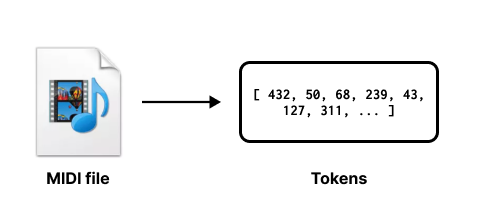

### MidiTok

The MidiTok library provides predefined tokenization methods (e.g. **REMI**) to translate MIDI events into tokens and vice versa, ensuring a structured and efficient representation of musical data.

Compared to the previous tokenization method, MidiTok allows for a more comprehensive translation of MIDI events into tokens, with less information loss.

In [ ]:
# BEAT_RES defines the temporal resolution for tokenizing MIDI events,
# mapping beat intervals to the number of subdivisions per beat.
BEAT_RES = {(0, 1): 12, (1, 2): 4, (2, 4): 2, (4, 8): 1}

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),         # ranges of possible pitches
    "beat_res": BEAT_RES,
    "num_velocities": 3,              # number of possible velocities for notes
    "special_tokens": ["BOS", "EOS"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "num_tempos": 8,
    "tempo_range": (50, 200),         # (min_tempo, max_tempo),
}

config = TokenizerConfig(**TOKENIZER_PARAMS)

# REMI is only one of the tokenization method available in MidiTok
# Here this one is used since it's been proven to work effectively
tokenizer = REMI(config)

### (Optional): train the tokenizer

One of the features that MidiTok offers is the **training of a tokenizer**.
Taken from MidiTok's documentation:

> Training a tokenizer consists in populating the vocabulary with new tokens representing successions of these basic tokens, that will be fetched from a training corpus. [...] For symbolic music, training the tokenizer allows to **increase both the model’s performances and efficiency**.

In order to do that, MidiTok uses algorithms like **Byte Pair Encoding (BPE)** to "pack" groups of tokens that appear frequently in the dataset into new tokens of the vocabulary.

The explanation for why this technique can improve the model’s performance is quite simple: the model’s “effort” in generating meaningful token sequences is reduced. Instead of learning to produce multiple “correct” tokens in sequence, it can directly produce a single token that corresponds to that sequence of MIDI events.

In [ ]:
# @title Manually train the tokenizer
TRAIN_TOKENIZER = False # @param { type: 'boolean' }

In [ ]:
vocab_size = 5000
if TRAIN_TOKENIZER:
  tokenizer.train(vocab_size=vocab_size, files_paths=midis)
  processed = [Path(f"{s}") for s in midis]
  print(len(processed))

### Load a trained tokenizer

To avoid re-training a tokenizer from scratch, here we provide an already trained one.

In [ ]:
!gdown 1Uf734gntq6RLpAvcruWuKcHqPmcZ_4O8
tokenizer = REMI(params="gan_tokenizer.json")
print(f"Vocab size: {len(tokenizer)}")

## Dataset preparation

In the following cells we prepare the dataset for training by splitting it into Train and Validation set. In addition, we exploit some methods made available by MidiTok to perform data augmentation.

### Download the clean data

If you want to skip all the data preparation, here we provide the data already cleaned and tokenized, in the form of numpy arrays.

In [ ]:
!gdown 1VU4ngttqwACFEtnv7l6B8xG2Z1eS3GWZ # ids_train_1227.txt
!gdown 1c8hgL4J2BVS4_XXuZNlkuTRYEHduZTdy # ids_valid_1227.txt

all_ids_train = np.loadtxt("ids_train_1227.txt").astype(dtype=np.int32)
all_ids_valid = np.loadtxt("ids_valid_1227.txt").astype(dtype=np.int32)

In [ ]:
# @title ### (Optional): skip all the data preparation
SKIP_DATA_PREPARATION = True # @param { type: 'boolean' }

In [ ]:
if not SKIP_DATA_PREPARATION:
  valid_perc = 0.05
  augment = True

  total_num_files = len(processed)
  num_files_valid = round(total_num_files * valid_perc)
  shuffle(processed)
  midi_paths_valid = processed[:num_files_valid]
  midi_paths_train = processed[num_files_valid:]

  # Chunk MIDIs and perform data augmentation on each subset independently

  for files_paths, subset_name in (
      (midi_paths_train, "train"),
      (midi_paths_valid, "valid"),
  ):

      # Split the MIDIs into chunks of sizes approximately about 1024 tokens
      subset_chunks_dir = Path(f"Maestro_{subset_name}")

      split_files_for_training(
          files_paths=files_paths,
          tokenizer=tokenizer,
          save_dir=subset_chunks_dir,
          max_seq_len=1024,
          num_overlap_bars=2,
      )

      # Perform data augmentation
      if augment:
          augment_dataset(
              subset_chunks_dir,
              pitch_offsets=[-12, 12],
              velocity_offsets=[-3, 3],
              duration_offsets=[-0.5, 0.5],
          )

  midi_paths_train = list(Path("Maestro_train").glob("**/*.mid")) + list(Path("Maestro_train").glob("**/*.midi"))
  midi_paths_valid = list(Path("Maestro_valid").glob("**/*.mid")) + list(Path("Maestro_valid").glob("**/*.midi"))

### Tokenization

Here we tokenize the augmented dataset into JSON files containing the IDs of the tokens.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def midi_valid(midi) -> bool:
      if any(ts.numerator != 4 for ts in midi.time_signature_changes):
          return False  # time signature different from 4/*, 4 beats per bar
      return True

  if os.path.exists("tokenized"):
    shutil.rmtree("tokenized")

  for dir in ("train", "valid"):
      tokenizer.tokenize_dataset(
          Path(f"Maestro_{dir}"),
          Path(f"tokenized_{dir}"),
          midi_valid,
      )

### Read JSON files

Here we read the produced JSON files containing MidiTok tokenization's output.

In [ ]:
if not SKIP_DATA_PREPARATION:
  def read_json(path: str) -> dict:
    with open(path, "r") as f:
      return json.load(f)

  def read_json_files(json_file_paths):
      """Reads a list of JSON files and returns a list of objects.
      Args:
          json_file_paths: A list of file paths to JSON files.
      Returns:
          A list of objects, where each object represents the data from a JSON file.
          Returns an empty list if any error occurs during file processing.
      """
      objects = []
      for file_path in tqdm(json_file_paths):
          try:
              objects.append(read_json(file_path))
          except FileNotFoundError:
              print(f"Error: File not found - {file_path}")
              return []
          except json.JSONDecodeError:
              print(f"Error decoding JSON in file: {file_path}")
              return []
      return objects

  tokenized_train = list(Path("tokenized_train").resolve().glob("**/*.json"))
  data_objects_train = read_json_files(tokenized_train)

  tokenized_valid = list(Path("tokenized_valid").resolve().glob("**/*.json"))
  data_objects_valid = read_json_files(tokenized_valid)

  if data_objects_train and data_objects_valid:
      print(f"\nSuccessfully read {len(data_objects_train)} training JSON files.")
      print(f"Successfully read {len(data_objects_valid)} validation JSON files.")
  else:
      print("Error reading JSON files.")

### Concatenate all IDs into a numpy array

Instead of working with padded songs (where each MIDI file, translated into tokens, is padded with a special padding token to reach a fixed length), we adopt a different approach. The token IDs of all piano pieces are concatenated into a single, large NumPy array.

While this method has clear drawbacks — such as reduced musical coherence when feeding the data into the model and a diminished sense of a song “as a whole” — it offers significantly greater flexibility in managing the data.

In [ ]:
if not SKIP_DATA_PREPARATION:
  encoded_train = [np.array(song["ids"][0]) for song in data_objects_train]
  encoded_valid = [np.array(song["ids"][0]) for song in data_objects_valid]
  all_ids_train = np.concatenate(encoded_train)
  all_ids_valid = np.concatenate(encoded_valid)

  all_ids_train = all_ids_train.astype(dtype=np.int32)
  all_ids_valid = all_ids_valid.astype(dtype=np.int32)

# GAN Model
The system consists of two main components:
1. **Generator Network**: A fully connected neural network that takes a random noise vector as input and generates a MIDI file as output (Generated MIDI). The goal of the generator is to produce data that closely resembles the real data.
2. **Discriminator Network**: Another fully connected neural network that takes as input both real MIDI files (from the **Maestro Dataset**) and MIDI files generated by the generator. The discriminator's role is to classify these inputs as either real (True) or fake (False).

***Training Process***
- The generator improves its performance by attempting to deceive the discriminator, generating data that the discriminator struggles to distinguish from real data.
- Simultaneously, the discriminator is optimized to become increasingly accurate at distinguishing real data from generated data.
- This adversarial process relies on a loss function calculated for both the generator and discriminator, with updates performed using the **ADAM** optimizer.

***Implementation Choices***
- *Fully connected networks* showed the best performance compared to other configurations we tested, such as **LSTM networks**. Although LSTMs leverage sequential context, they yielded inferior results in this application, likely due to the specific nature of the MIDI data representation or problem at hand.
- The loss function used for the discriminator is **BCEWithLogitsLoss**, which is well-suited for binary classification tasks.
- The loss function used for the generator is _non-saturating_ GAN loss.

The **Maestro Dataset**, a rich collection of high-quality real MIDI files, was used to train the discriminator, providing a robust foundation for distinguishing real from generated data.

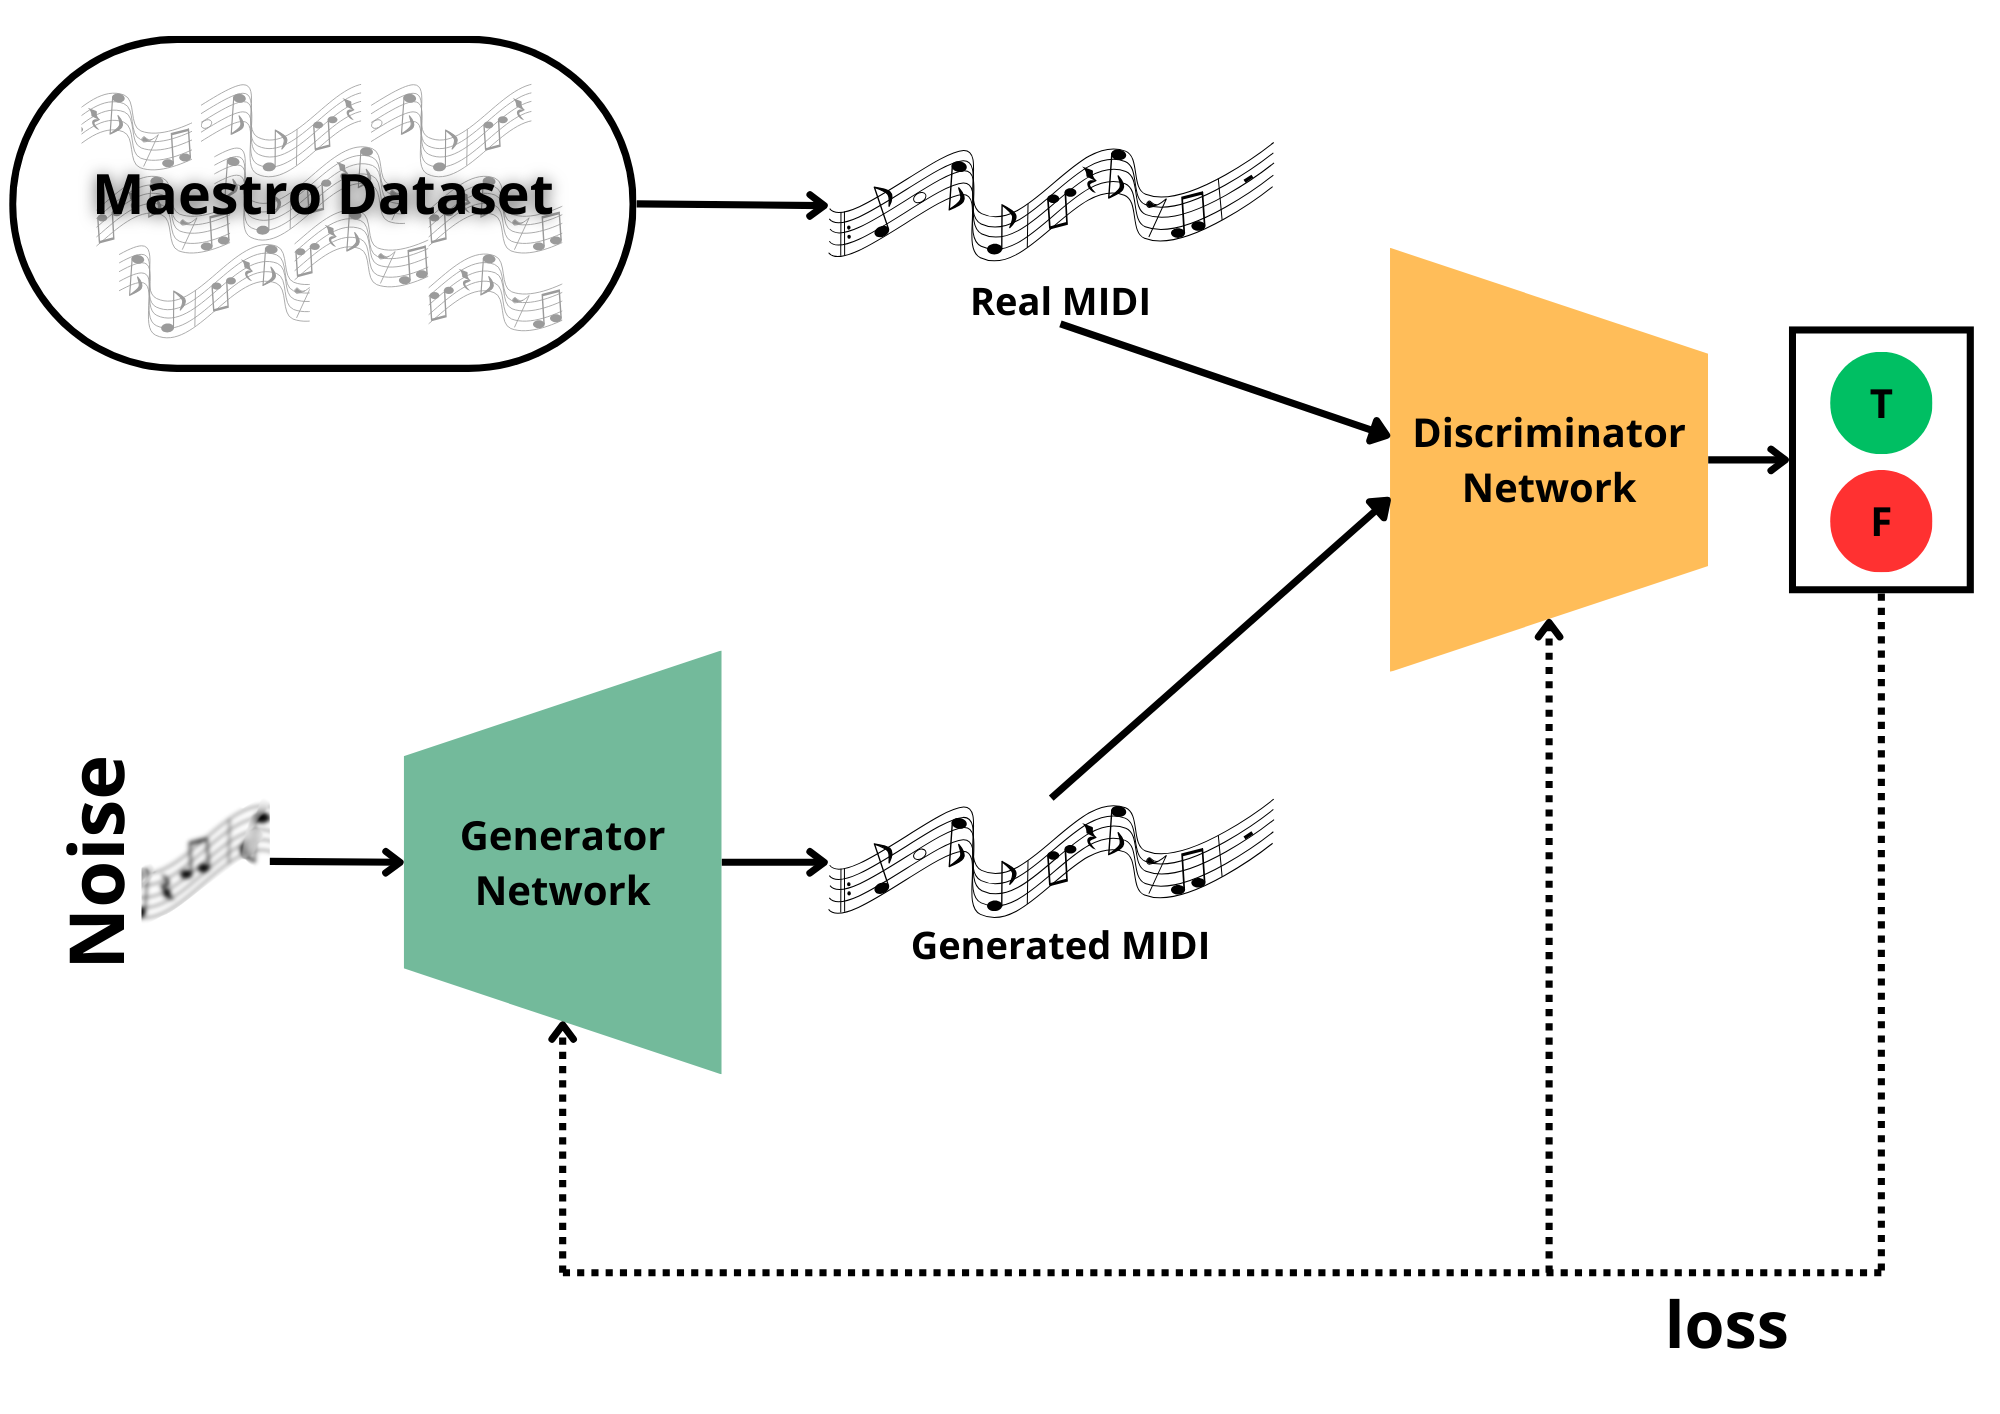

## Generator
These are the tested generator models, the final one is the _FC4_

In [ ]:
class GenLSTM(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length, num_layers, drop_rate=0.3):
        super(GenLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_rate)
        self.fc1 = nn.Linear(hidden_dim, seq_length)
        self.bn1 = nn.BatchNorm1d(noise_dim)
        self.lrelu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(seq_length, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.lrelu1(x)
        x = self.fc2(x)
        return self.tanh(x)

class GenFC1(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC1, self).__init__()
        self.fc1 = nn.Linear(noise_dim, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, seq_length)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Output will be of shape (batch_size, seq_length)
        return x


class GenFC4(nn.Module):
    def __init__(self, noise_dim, hidden_dim, seq_length):
        super(GenFC4, self).__init__()
        self.fc1 = nn.Linear(noise_dim, hidden_dim * 16)
        self.fc2 = nn.Linear(hidden_dim * 16, hidden_dim * 8)
        self.fc3 = nn.Linear(hidden_dim * 8, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, seq_length)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return torch.tanh(x)

## Discriminator (choose one)

In [ ]:
class DiscLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(DiscLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.leaky_relu2 = nn.LeakyReLU(0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        # LSTM expects input as (batch_size, seq_len, input_dim)
        _, (h_n, _) = self.lstm(x)  # Only use the last hidden state (h_n)
        x = h_n[-1]  # h_n contains layers, take the last layer's output
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.fc3(x)
        return x

class DiscFC1(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC1, self).__init__()
        self.fc1 = nn.Linear(seq_length, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class DiscFC4(nn.Module):
    def __init__(self, seq_length, hidden_dim):
        super(DiscFC4, self).__init__()
        self.fc1 = nn.Linear(seq_length, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc3 = nn.Linear(hidden_dim * 4, hidden_dim * 8)
        self.fc4 = nn.Linear(hidden_dim * 8, hidden_dim * 16)
        self.fc5 = nn.Linear(hidden_dim * 16, 1)
        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.dropout(self.leaky_relu(self.fc3(x)))
        x = self.dropout(self.leaky_relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Hyper-parameters and models

In [ ]:
def get_model(name: str, config: dict):
    if name == "gen_fc1":
        return GenFC1(**config)
    elif name == "gen_fc4":
        return GenFC4(**config)
    elif name == "gen_lstm":
        return GenLSTM(**config)
    elif name == "disc_fc1":
        return DiscFC1(**config)
    elif name == "disc_fc4":
        return DiscFC4(**config)
    elif name == "disc_lstm":
        return DiscLSTM(**config)
    else:
        raise KeyError("Unknown model")

vocab_size = len(tokenizer)
seq_length = 512
noise_dim = 512
hidden_dim = 1536
batch_size = 128

generator_config = {
    "noise_dim"  : noise_dim,
    "hidden_dim" : hidden_dim,
    "seq_length" : seq_length
}


discriminator_config = {
    "seq_length" : seq_length,
    "hidden_dim" : hidden_dim
}

generator = get_model("gen_fc4", generator_config)
discriminator = get_model("disc_fc4", discriminator_config)

gan_params = {
    "generator"                : generator,
    "discriminator"            : discriminator,
    "noise_dim"                : noise_dim,
    "seq_length"               : seq_length,
    "tokenizer"                : tokenizer,
}

## GAN class
A GAN class was created, in order to abstract the training specification of PyTorch, to facilitate training and subsequent output generation.

In [ ]:
class GAN:
    def __init__(self,
                 generator,
                 discriminator,
                 noise_dim,
                 seq_length,
                 tokenizer,
                 loss = nn.BCEWithLogitsLoss(),
                ):
        self.G = generator
        self.D = discriminator
        self.noise_dim = noise_dim
        self.seq_length = seq_length
        self.loss = loss

        self.optimizer_G = torch.optim.Adam(self.G.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=0.00005, betas=(0.5, 0.999))
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer)

        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        # Initialize all layers
        self.G.apply(init_weights)
        self.D.apply(init_weights)

    def _weights_init(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    def noise(self, size, device):
        return torch.randn(size, self.noise_dim, device=device)

    def _G_train_step(self, batch_size, device):
        self.G.zero_grad()

        # Generate fake data
        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)

        fake_preds = self.D(fake_data)

        epsilon = 1e-8
        loss_G = -torch.mean(fake_preds)

        # Check for NaNs and clip gradients
        if torch.isnan(loss_G).any() or torch.isinf(loss_G).any():
            print(f"NaN or Inf detected in G Loss")
        else:
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(self.G.parameters(), max_norm=1.0)
            self.optimizer_G.step()

        return loss_G

    def _D_train_step(self, batch_size, real_data, device):
        self.D.zero_grad()

        fake_noise = self.noise(batch_size, device)
        fake_data = self.G(fake_noise)
        #print(f"Fake data in D step {fake_data}")
        #print(f"Real data in D step {real_data}")

        real_preds = self.D(real_data)
        fake_preds = self.D(fake_data)
        #print(f"Real Preds in D step {real_preds}")
        #print(f"Fake Preds in D step {torch.mean(fake_preds)}")

        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)

        loss_real = self.loss(real_preds, real_labels)
        loss_fake = self.loss(fake_preds, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        self.optimizer_D.step()

        if torch.isnan(loss_D).any() or torch.isinf(loss_D).any():
            print(f"NaN or Inf detected in D Loss")

        return loss_D

    def _train_step(self, batch_size, real_data, device, gen_steps=1, disc_steps=1):
        losses_D = []
        losses_G = []
        for i in range(disc_steps):
            losses_D.append(self._D_train_step(batch_size, real_data, device))
        for i in range(gen_steps):
            losses_G.append(self._G_train_step(batch_size, device))
        return (losses_D, losses_G)


    def train(
        self,
        dataloader,
        epochs,
        device,
        loss_delta=0.7,
        steps_each_print=5,
        advantage_steps=2,
        alternate_training=False,
        gen_steps=1,
        disc_steps=1,
    ):
        print(f"Starting training with {epochs} epochs")
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        self.G.train(True)
        self.D.train(True)

        iteration_count = len(dataloader)
        batch_size = dataloader.batch_size

        disc_steps = disc_steps
        gen_steps = gen_steps

        final_losses_D = []
        final_losses_G = []

        for epoch in range(epochs):
            pbar = tqdm(total=iteration_count, position=0, leave=True)
            for step, real_data in enumerate(dataloader):
                batch_size = real_data.size(0)
                real_data = real_data.to(device)

                losses_D, losses_G = self._train_step(batch_size, real_data, device, gen_steps, disc_steps)
                losses_D = [loss.cpu().item() for loss in losses_D]
                losses_G = [loss.cpu().item() for loss in losses_G]
                loss_D, loss_G = (np.mean(losses_D), np.mean(losses_G))
                final_losses_D.append(loss_D)
                final_losses_G.append(loss_G)

                if alternate_training:
                    if loss_G - loss_D > loss_delta:
                        gen_steps = advantage_steps
                        disc_steps = 1
                    elif loss_D - loss_G  > loss_delta:
                        disc_steps = advantage_steps
                        gen_steps = 1
                    else:
                        gen_steps = 1
                        disc_steps = 1

                if (step + 1) % steps_each_print == 0:
                    description = f"D Loss: {loss_D:.4f}, G Loss: {loss_G:.4f}"
                    if gen_steps != 1 or disc_steps != 1:
                        description = description + f", D Steps: {disc_steps}, G Steps: {gen_steps}"
                    pbar.set_description(description)
                    pbar.update(steps_each_print)
            pbar.n = pbar.total
            pbar.refresh()
            pbar.close()

            print(f'Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

        return final_losses_D, final_losses_G

    def save_generator(self, directory):
        torch.save(self.G, directory)

    def predict(self, n, device):
        z = self.noise(n, device) # Random Noise
        return self.G(z).cpu().detach().numpy()

    def generate(self, n, base_output_name, device):
        normalized_predictions = self.predict(n, device)
        boundary = int(len(tokenizer) / 2)
        predictions = [x * boundary + boundary for x in normalized_predictions]
        for i in range(len(predictions)):
            pred = predictions[i]                                # [[5.0], [6.0], [7.0]]
            pred_tokens = pred.astype(np.int32)                  # [5, 6, 7]
            pred_tokens[pred_tokens == len(tokenizer)] = 0       # if some value equals vocab_size, replace with empty tokens
            try:
                decoded = tokenizer.decode([pred_tokens])
                decoded.dump_midi(f"{base_output_name}_{i}.mid")
            except Exception as e:
                print(e)

gan = GAN(**gan_params)

# Training

## Prepare data
1. **Custom Dataset Class:**  
   A `TokenDataset` class is implemented to encapsulate tokenized and normalized sequences. This class ensures compatibility with PyTorch's `DataLoader`, which allows for efficient data loading during training.

2. **Normalization:**  
   Tokenized data is normalized to a specified range (e.g., [-1, 1]) to improve model performance. This step rescales token values relative to the vocabulary size, making the data more suitable for neural network training.

3. **Sequence Preparation:**  
   The normalized data is divided into smaller sequences of fixed length.

4. **Dataset and DataLoader:**  
   The prepared sequences are encapsulated in the `TokenDataset` class. A PyTorch `DataLoader` is then used to batch the data, shuffle it for training randomness, and load it efficiently.


In [ ]:
class TokenDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

vocab_size = len(tokenizer)

def normalize_data(data, vocab_size, interval=(-1, 1)):
    min_val, max_val = interval
    normalized_data = (data - vocab_size / 2) / (vocab_size / 2)
    scaled_data = normalized_data * (max_val - min_val) / 2 + (max_val + min_val) / 2

    return scaled_data

normalized_seq = normalize_data(all_ids_train, vocab_size)
print(f"Max is {normalized_seq.max()}, Min is {normalized_seq.min()}")

all_ids_train_seq = [normalized_seq[i:i + seq_length]
                 for i in range(0, len(normalized_seq) - seq_length, seq_length)]

dataset = TokenDataset(all_ids_train_seq)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
_ = torch.ones(1, device='cuda')  # Dummy operation to initialize CUDA

## Start the training
It is possible to skip the training and download the already trained model by setting the "Train" flag.
The following cell downloads the generator and allows it to be loaded.

In [ ]:
!gdown 1XN71Mnc3C4gzr1w8u5xgcOAsX9zNds-m
generator = torch.load("./NESGEN_gan50")
!rm NESGEN_gan50

In [ ]:
# @title ### (Optional): skip training
TRAIN = False # @param { type: 'boolean' }

In [ ]:
training_arguments = {
    "dataloader"         : dataloader,
    "epochs"             : 50,
    "device"             : device,
    "steps_each_print"   : 10,
    "gen_steps"          : 1,
    "disc_steps"         : 1,
}
if TRAIN:
  losses_D, losses_G = gan.train(**training_arguments)

### Print losses


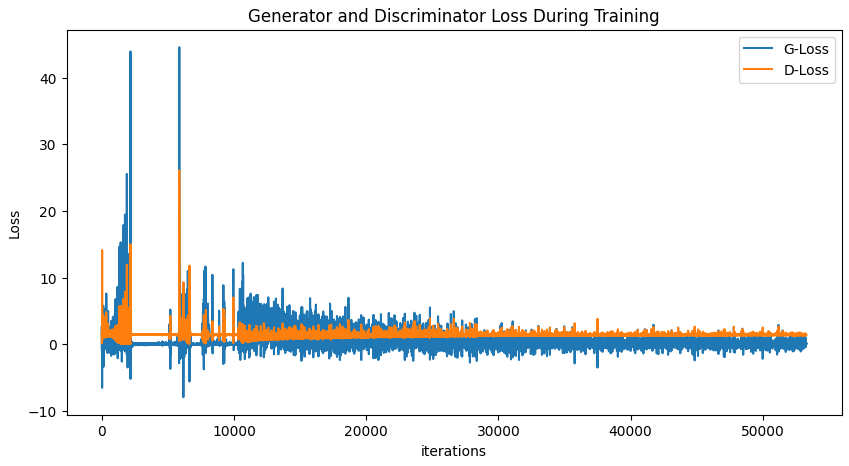

## Generation

The following cells show how it is possible to generate new MIDI music using this model.

In [ ]:
noise_dim = 512
def noise(size, device):
  return torch.randn(size, noise_dim, device=device)

def predict(generator, n, device):
  z = noise(n, device) # Random Noise
  return generator(z).cpu().detach().numpy()

def generate(generator, n, base_output_name, device):
  normalized_predictions = predict(generator, n, device)
  boundary = int(len(tokenizer) / 2)
  predictions = [x * boundary + boundary for x in normalized_predictions]
  for i in range(len(predictions)):
      pred = predictions[i]
      pred_tokens = pred.astype(np.int32)
      pred_tokens[pred_tokens == len(tokenizer)] = 0
      try:
          decoded = tokenizer.decode([pred_tokens])
          decoded.dump_midi(f"{base_output_name}_{i}.mid")
      except Exception as e:
          print(e)

In [ ]:
normalized_predictions = predict(generator, 2, device)
boundary = int(len(tokenizer) / 2)
predictions = [x * boundary + boundary for x in normalized_predictions]

In [ ]:
n_generations = 100
folder_name = "generated"
base_name = f"{folder_name}/generated_midi"

os.makedirs(folder_name, exist_ok=True)

generate(
    generator         = generator,
    n                 = n_generations,
    base_output_name  = base_name,
    device            = device,
)

In [ ]:
display_audio(f"{base_name}_10.mid")

# Metrics calculation

## Obtain the generated datasets

Here we first download a small dataset of MIDI music generated with both models (pre-trained and fine-tuning).

In [ ]:
%%capture
!rm -rf generated/
!rm NESGEN_gan_100generations.zip
!gdown 1CyGlWIRQjaEZBYfS8s0U8sEuAnubvSSU
!unzip NESGEN_gan_100generations.zip

import glob

maestro_midis = list(glob.glob("generated/*.mid"))

### Load trained tokenizers

In [ ]:
!gdown 1Uf734gntq6RLpAvcruWuKcHqPmcZ_4O8

maestro_tokenizer = REMI(params=Path("gan_tokenizer.json"))

print(f"Vocab size: {len(maestro_tokenizer)}")

### Tokenize the generated datasets

In [ ]:
maestro_tokenized = [maestro_tokenizer.encode(midi)[0].ids for midi in maestro_midis]

### Zip the files

In [ ]:
maestro_dataset = list(zip(maestro_midis, maestro_tokenized))

### Download training set

For some metrics, it's necessary to have also the training set.

In [ ]:
!gdown 1VU4ngttqwACFEtnv7l6B8xG2Z1eS3GWZ

all_ids_maestro_train = np.loadtxt("ids_train_1227.txt").astype(np.int32)

## Metrics definition

### Utility functions

In [ ]:
def get_duration_ratio(note_start, note_end, tempo, time_signature):
    """
    Calculate the duration ratio for a note.

    Args:
        note_start (float): Start time of the note in seconds.
        note_end (float): End time of the note in seconds.
        tempo (float): Tempo in beats per minute.
        time_signature (tuple): Tuple of (numerator, denominator) of time signature.

    Returns:
        Fraction: Duration as a beat ratio.
    """
    duration_seconds = note_end - note_start
    beats_per_second = tempo / 60
    beat_duration = duration_seconds * beats_per_second

    # Quantize to nearest valid ratio based on time signature
    denominator = time_signature[1]
    ratio = Fraction(beat_duration).limit_denominator(denominator)
    return ratio

def midi_to_tokens(file_path, valid_ratios, tempo=120, time_signature=(4, 4)):
    """
    Convert a MIDI file into tokens for metric calculations.

    Args:
        file_path (str): Path to the MIDI file.
        valid_ratios (set of Fraction): Set of valid beat ratios.
        tempo (float): Tempo in beats per minute.
        time_signature (tuple): Time signature as (numerator, denominator).

    Returns:
        list of tuple: Tokenized sequence as (pitch, duration_ratio).
    """
    midi = pretty_midi.PrettyMIDI(file_path)
    tokens = []

    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            duration_ratio = get_duration_ratio(
                note.start, note.end, tempo, time_signature
            )
            tokens.append((note.pitch, duration_ratio))

    return tokens

def contains_sequence(array, sequence):
    """
    Checks if 'array' contains 'sequence'
    """
    seq_len = len(sequence)
    sub_arrays = np.lib.stride_tricks.sliding_window_view(array, seq_len)
    return np.any(np.all(sub_arrays == sequence, axis=1))


def extract_token_sequences(tokens: list, sequence_length: int, stride: int = 1) -> set[tuple]:
    """
    Extracts sequences of a specific length from a bigger list
    """
    return {tuple(tokens[i:i + sequence_length]) for i in range(0, len(tokens) - sequence_length + 1, stride)}


### Qualified Rhythm Frequency (QR)

Measures the frequency of note durations that have a valid beat ratio (e.g., 1/2, 1/4, 1/16, etc.).

In [ ]:
import numpy as np
from fractions import Fraction
from collections import Counter
import pretty_midi

def calculate_qr(tokens: list[tuple]) -> float:
    """
    Calculate Qualified Rhythm Frequency (QR).

    Args:
        tokens (list of tuple): Tokenized MIDI sequence as tuples of (pitch, duration_ratio).
        valid_ratios (set of Fraction): Set of valid beat ratios.

    Returns:
        dict: Frequency of valid durations.
    """
    n_notes = 0
    for _, duration_ratio in tokens:
        if duration_ratio in valid_ratios:
            n_notes += 1

    return n_notes / len(tokens)

### Consecutive Pitch Repetitions (CPR)

For a given length `l`, it measures the frequency of occurrences of `l` consecutive pitch repetitions.

In [ ]:
def calculate_cpr(tokens, l_values) -> float:
    """
    Calculate Consecutive Pitch Repetitions (CPR).

    Args:
        tokens (list of tuple): Tokenized MIDI sequence as tuples of (pitch, duration_ratio).
        l_values (list of int): List of l values to evaluate.

    Returns:
        dict: Frequency of l consecutive pitch repetitions.
    """
    pitch_repetitions = Counter()

    # Extract pitches from tokens
    pitches = [pitch for pitch, _ in tokens]

    for l in l_values:
        count = 0
        for i in range(len(pitches) - l + 1):
            if len(set(pitches[i:i + l])) == 1:  # All pitches are identical
                count += 1
        pitch_repetitions[l] = count

    cpr_frequency = {l: count / len(pitches) for l, count in pitch_repetitions.items()}
    return cpr_frequency

### Average Rote Memorization Frequency (RM)

Given a sequence length `l`, RM measures how frequently the model copies note sequences of length `l` from the dataset.

In [ ]:
def calculate_rm(
    training_set_tokens: np.ndarray,
    generated_sequences: list[np.ndarray],
    sequence_length: int,
    stride: int = 1
) -> float:
    """
    Calculate the Rote Memorization Frequency (RM) based on tokens.

    Args:
        training_set_tokens: array of tokens from the training set.
        generated_sequences: list of arrays of generated tokens.
        sequence_length: length of the token sequences.
    Returns:
        Rote Memorization Frequency (RM) calculated on all the generated sequences
    """
    total_copied_sequences = 0
    total_sequences = 0
    train_seqs_of_length_l = extract_token_sequences(training_set_tokens, sequence_length, stride)

    for sequence in tqdm(generated_sequences):
        seqs_of_length_l = extract_token_sequences(sequence, sequence_length, stride)
        n_copied_sequences = sum(1 for sub_seq in seqs_of_length_l if sub_seq in train_seqs_of_length_l)
        total_copied_sequences += n_copied_sequences
        total_sequences += len(seqs_of_length_l)

    return total_copied_sequences / total_sequences


### Final calculation of Metrics

In [ ]:
valid_ratios = {
    Fraction(1, 2),
    Fraction(1, 4),
    Fraction(1, 8),
    Fraction(1, 16),
    Fraction(1, 3),
    Fraction(1, 6),
}

def reduce_dicts(dict_list: list[dict]) -> dict:
  sums = Counter()
  counts = Counter()

  for d in dict_list:
      for key, value in d.items():
          sums[key] += value
          counts[key] += 1

  return {key: sums[key] / counts[key] for key in sums}

def calculate_metrics(
    dataset: list[tuple],
    training_set_tokens: np.ndarray,
    valid_ratios=valid_ratios,
    l_values=[2, 3, 4],
    rm_seq_length=8,
    rm_stride=8
):
    qr_metrics = []
    cpr_metrics = []
    tokenized = list(map(lambda x: x[1], dataset))

    print("Calculating QR and CPR...")
    for file_path, _ in dataset:
      tokens = midi_to_tokens(file_path, valid_ratios)
      if len(tokens) == 0:
        print(f"Excluding {file_path} as it contains no note")
        continue

      qr_metrics.append(calculate_qr(tokens))
      cpr_metrics.append(calculate_cpr(tokens, l_values))

    cpr_metrics = reduce_dicts(cpr_metrics)
    qr_metrics = np.mean(qr_metrics)

    print("Done.\nCalculating RM")
    rm_metrics = calculate_rm(training_set_tokens, tokenized, sequence_length=rm_seq_length, stride=rm_stride)
    return {'qr': qr_metrics, 'cpr': cpr_metrics, 'rm' : rm_metrics}

In [ ]:
maestro_metrics = calculate_metrics(maestro_dataset, all_ids_maestro_train, rm_seq_length=4, rm_stride=2)

Calculating QR and CPR...
Done.
Calculating RM


100%|██████████| 100/100 [00:00<00:00, 1598.47it/s]


In [ ]:
from tabulate import tabulate

metric_table = [
    {
        "Dataset": "Maestro",
        "QR (%)": maestro_metrics["qr"] * 100,
        "CPR (%)": {beat: round(value * 100, ndigits=2) for beat, value in maestro_metrics["cpr"].items()},
        "RM (%)": maestro_metrics["rm"] * 100
    }
]

print(tabulate(metric_table, headers = "keys", tablefmt="orgtbl"))


| Dataset   |   QR (%) | CPR (%)                    |   RM (%) |
|-----------+----------+----------------------------+----------|
| Maestro   |   17.951 | {2: 4.22, 3: 0.14, 4: 0.0} | 0.344069 |
